# Installing necessary packages

In [1]:
try:
    import fairlearn
    print("fairlearn is already installed.")
except ImportError:
    print("fairlearn is not installed. Installing now...")
    !pip install fairlearn

fairlearn is not installed. Installing now...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.0/240.0 kB 6.2 MB/s eta 0:00:00


In [2]:
try:
    import lime
    print("limr is already installed.")
except ImportError:
    print("lime is not installed. Installing now...")
    !pip install lime



limr is already installed.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
import warnings

## LIBS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import fairlearn
import shap
import lightgbm as lgb
import xgboost as xgb
import warnings

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score,confusion_matrix

from functools import partial
import os
from sklearn.metrics import accuracy_score, precision_score
from fairlearn.metrics import (
    MetricFrame,
    demographic_parity_difference,
    equalized_odds_difference,
    demographic_parity_ratio,
)
from lime.lime_tabular import LimeTabularExplainer

os.environ['KMP_DUPLICATE_LIB_OK']='True'

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Data Pre-procesing

## Helper method for handling data pre-processing

In [4]:
# Data Pre-processing pipelines
class DataPreprocessor:
    def __init__(self, file_path):
        """
        Initialize the DataPreprocessor with the dataset path.
        
        Parameters:
        file_path (str): Path to the CSV dataset file.
        Inspiration from: https://www.kaggle.com/code/saulotoledopereira/simple-data-cleaning-and-comparing-9-models
        """
        self.file_path = file_path
        self.data = None
        self.encoder = None

    def load_data(self):
        """Load the dataset from the file path."""
        self.data = pd.read_csv(self.file_path)
        print("Data loaded successfully.")

    def preprocess_data(self):
        """
        Perform preprocessing on the loaded dataset.
        """
        if self.data is None:
            raise ValueError("Data not loaded. Please call `load_data()` first.")

        # Drop unnecessary columns
        self.data = self.data.drop(['id'], axis=1)

        # Convert Gender to numeric
        self.data['Gender'] = self.data['Gender'].map({'Male': 0, 'Female': 1})

        # Filter Cities with fewer than 400 students
        city_counts = self.data['City'].value_counts()
        self.data = self.data[self.data['City'].isin(city_counts[city_counts >= 400].index)]

        # Keep only 'Student' in Profession column
        self.data = self.data[self.data['Profession'] == 'Student'].drop(['Profession'], axis=1)

        # Drop irrelevant columns
        self.data = self.data.drop(['Work Pressure'], axis=1)
        self.data = self.data[self.data['Age'] <= 30]
        self.data = self.data[self.data['Academic Pressure'] > 0]
        self.data = self.data[self.data['Study Satisfaction'] > 0]
        self.data = self.data.drop(['Job Satisfaction'], axis=1)

        # Process Sleep Duration
        sleep_map = {
            'Less than 5 hours': 0,
            '5-6 hours': 1,
            '7-8 hours': 2,
            'More than 8 hours': 3
        }
        self.data = self.data[self.data['Sleep Duration'] != 'Others']
        self.data['Sleep Duration'] = self.data['Sleep Duration'].map(sleep_map)

        # Process Dietary Habits
        diet_map = {'Healthy': 0, 'Unhealthy': 1, 'Moderate': 2}
        self.data = self.data[self.data['Dietary Habits'] != 'Others']
        self.data['Dietary Habits'] = self.data['Dietary Habits'].map(diet_map)

        # Map Degree to New Degree Categories
        degree_mapping = {
            r'BSc|BCA|B.Ed|BHM|B.Pharm|B.Com|BE|BA|B.Arch|B.Tech|BBA|LLB': 'Graduated',
            r'MSc|MCA|M.Ed|M.Pharm|M.Com|ME|MA|M.Arch|M.Tech|MBA|LLM': 'Post Graduated',
            'Class 12': 'Higher Secondary'
        }
        for pattern, category in degree_mapping.items():
            self.data.loc[self.data['Degree'].str.contains(pattern, regex=True, na=False), 'New_Degree'] = category

        self.data = self.data[self.data['Degree'] != 'Others']
        new_degree_map = {'Graduated': 0, 'Post Graduated': 1, 'Higher Secondary': 2}
        self.data['New_Degree'] = self.data['New_Degree'].map(new_degree_map)

        # Map Suicidal Thoughts and Family History
        self.data['Have you ever had suicidal thoughts ?'] = self.data['Have you ever had suicidal thoughts ?'].map({'Yes': 1, 'No': 0})
        self.data['Family History of Mental Illness'] = self.data['Family History of Mental Illness'].map({'Yes': 1, 'No': 0})

        # Drop missing values
        self.data = self.data.dropna()

        # One-Hot Encode City Column
        self.encoder = OneHotEncoder(sparse_output=False)
        encoded_cities = self.encoder.fit_transform(self.data[['City']])
        city_encoded_df = pd.DataFrame(encoded_cities, columns=self.encoder.get_feature_names_out(['City']), index=self.data.index)
        self.data = pd.concat([self.data, city_encoded_df], axis=1).drop(['City', 'Degree'], axis=1)

        print("Preprocessing complete.")

    def save_data(self, output_path):
        """
        Save the preprocessed dataset to a CSV file.
        
        Parameters:
        output_path (str): Path to save the processed dataset.
        """
        if self.data is None:
            raise ValueError("No data to save. Please preprocess the data first.")

        self.data.to_csv(output_path, index=False)
        print(f"Data saved to {output_path}.")

In [5]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/student-depression-dataset/Student Depression Dataset.csv


## We pre-process the dataset

In [6]:
preprocessor = DataPreprocessor(file_path='/kaggle/input/student-depression-dataset/Student Depression Dataset.csv')
preprocessor.load_data()
preprocessor.preprocess_data()
preprocessor.save_data(output_path=f'{os.getcwd()}/Processed_StudentDepression.csv')

Data loaded successfully.
Preprocessing complete.
Data saved to /kaggle/working/Processed_StudentDepression.csv.


## Load the cleaned data 

In [7]:
df = pd.read_csv(f'{os.getcwd()}/Processed_StudentDepression.csv')
FIG_PATH = "./graphics/"

# Check if the directory exists
if not os.path.exists(FIG_PATH):
    # Create the directory
    os.makedirs(FIG_PATH)
    print(f"Directory {FIG_PATH} created.")
else:
    print(f"Directory {FIG_PATH} already exists.")

Directory ./graphics/ created.


### We perform exploratory data analysis (EDA) using correlation matrice and heatmap

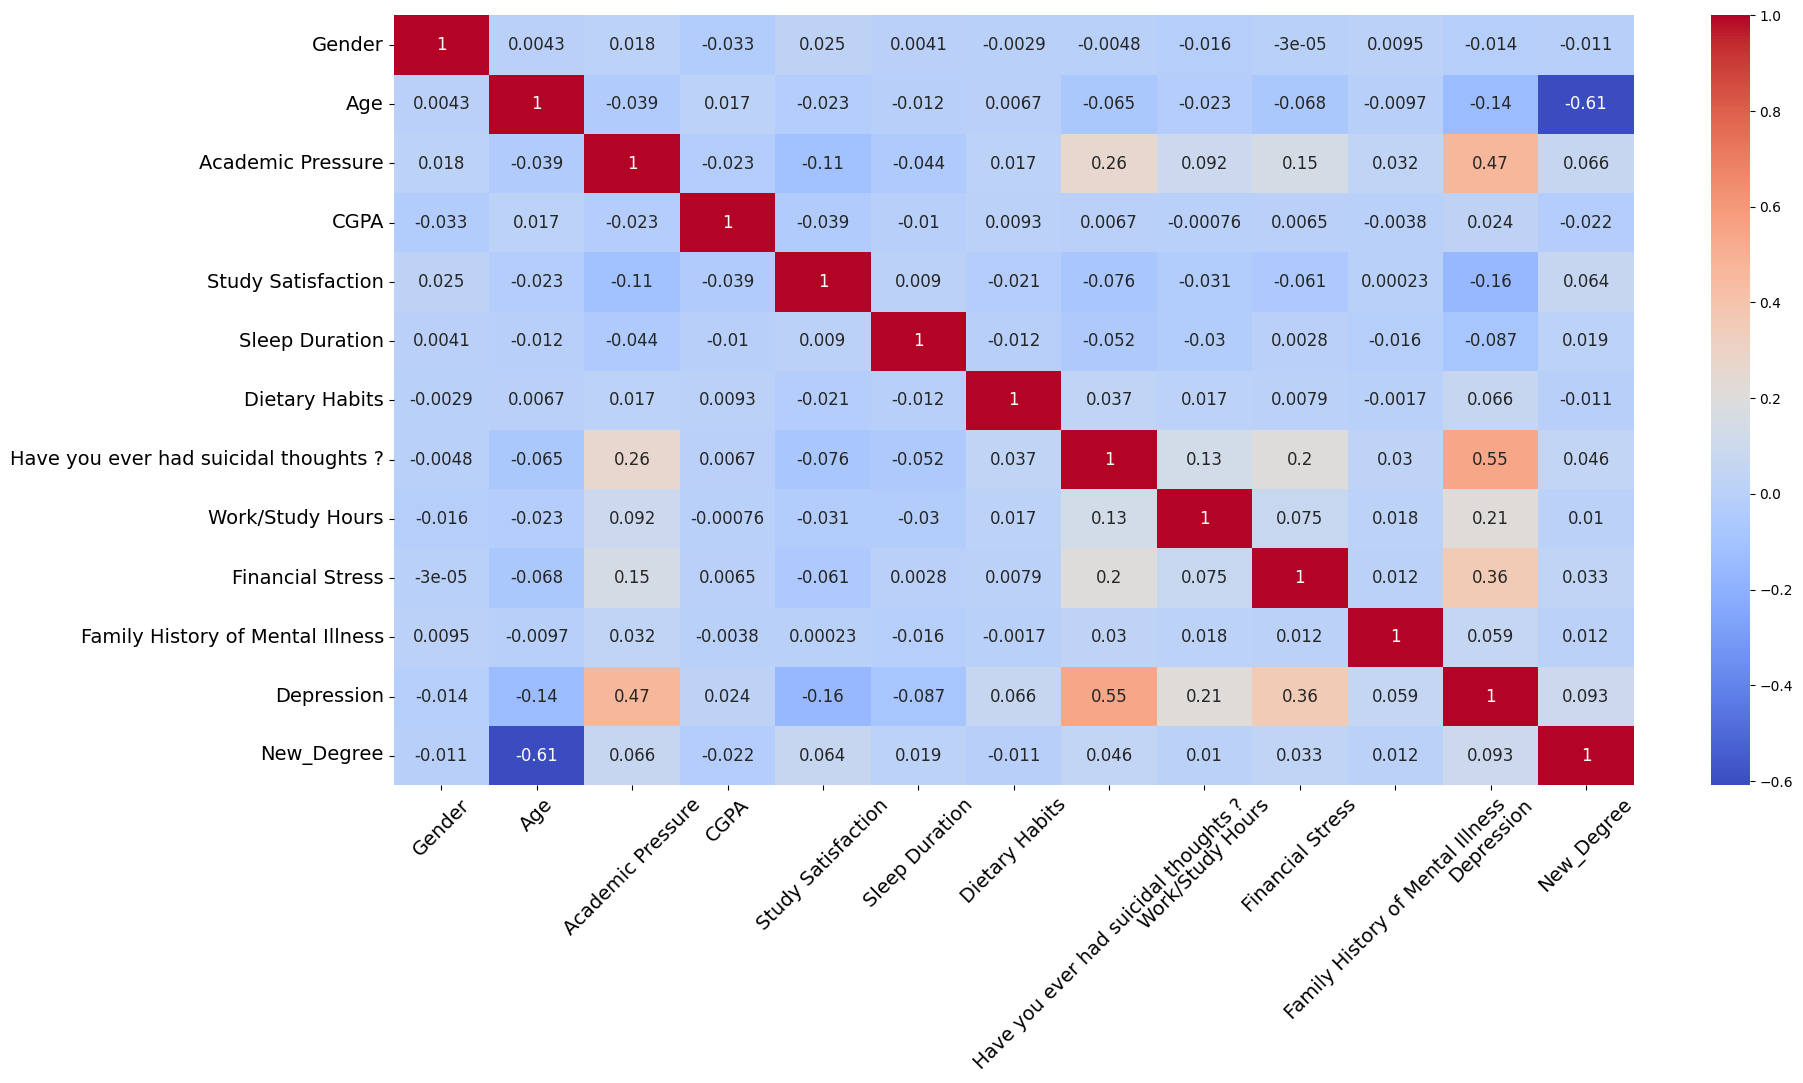

In [8]:
## PLOTTING THE CORRELATION MATRIX

main_data = df[['Gender', 'Age', 'Academic Pressure', 'CGPA',
       'Study Satisfaction', 'Sleep Duration', 'Dietary Habits',
       'Have you ever had suicidal thoughts ?', 'Work/Study Hours',
       'Financial Stress', 'Family History of Mental Illness', 'Depression',
       'New_Degree']]
main_data.head(3)

plt.figure(figsize=(20, 10))

# Plot the heatmap with increased annotation font size
sns.heatmap(
    main_data.corr(), 
    annot=True, 
    cmap='coolwarm', 
    annot_kws={"size": 12}  # Adjust the annotation font size
)

# Increase the size of the x and y-axis labels
plt.xticks(fontsize=14, rotation=45)  # Adjust fontsize and rotate labels
plt.yticks(fontsize=14)

# Save the plot to a file (e.g., as a PNG image)
plt.savefig(f'{FIG_PATH}mental_health_heatmap.png', bbox_inches='tight', dpi=300)
plt.show()

# Model training

## Split the data into train/test (80/20), standardize and test-run one classifier

In [9]:
## SPLITTING THE DATA INTO FEATURES AND TARGET
X = df.drop('Depression', axis=1).values  # Features
y = df['Depression'].values  # Target

## SPLITTING THE DATA INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## NORMALIZING THE DATA FEATURES USING STANDARD SCALER
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## TRAINING THE MODEL USING LOGISTIC REGRESSION
model = LogisticRegression()
model.fit(X_train_scaled, y_train)

## SCORE
score = model.score(X_test_scaled, y_test)
print(f"Accuracy: {score*100:.2f}%")

Accuracy: 85.29%


## Plot confusion matrix for the single trained classifier 

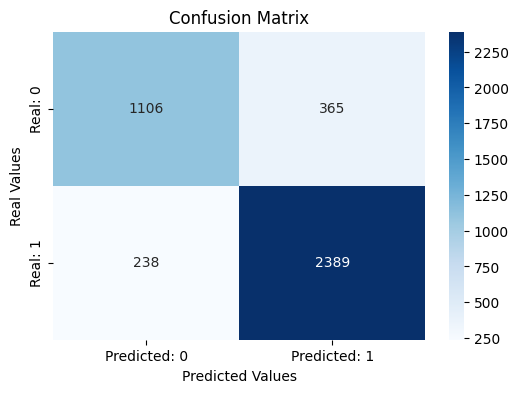

In [10]:
## PLLOTING THE CONFUSION MATRIX
y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Values')
plt.ylabel('Real Values')
# Save the plot to a file (e.g., as a PNG image)
plt.savefig(f'{FIG_PATH}mental_health_confusion_matrix.png', bbox_inches='tight', dpi=300)
plt.show()

## Next, we perform grid search over the parameter spaces for each model

In [11]:
from sklearn.model_selection import GridSearchCV

models = {
    "Logistic Regression": LogisticRegression(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "SVM": SVC(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "XGBoost": xgb.XGBClassifier(random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42, verbose=-1)
}


# Define the parameter grids for each model
param_grids = {
    "Logistic Regression": {
        "C": [0.01, 0.1, 1, 10],
        "solver": ["liblinear", "saga"],
        "max_iter": [100, 200, 300]
    },
    "Decision Tree": {
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Random Forest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [3, 5, 10, None],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4]
    },
    "Gradient Boosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 10]
    },
    "SVM": {
        "C": [0.01, 0.1, 1, 10],
        "kernel": ["linear", "rbf"],
        "gamma": ["scale", "auto"]
    },
    "K-Nearest Neighbors": {
        "n_neighbors": [3, 5, 10],
        "weights": ["uniform", "distance"],
        "algorithm": ["auto", "ball_tree", "kd_tree"]
    },
    "Naive Bayes": {},
    "XGBoost": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 10]
    },
    "LightGBM": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.1, 0.5],
        "max_depth": [3, 5, 10]
    }
}

# Initialize a dictionary to store the best model and its accuracy
best_model_results = {}

for name, model in models.items():
    print(f"Running GridSearchCV for {name}...")

    # Create a GridSearchCV object for each model and its respective parameter grid
    grid_search = GridSearchCV(model, param_grids[name], cv=2, n_jobs=-1, scoring="accuracy")
    
    # Fit the grid search
    grid_search.fit(X_train_scaled, y_train)
    
    # Get the best model and its accuracy
    best_model = grid_search.best_estimator_
    best_accuracy = grid_search.best_score_

    # Store the best model's accuracy and parameters
    best_model_results[name] = {
        "accuracy": best_accuracy,
        "best_params": grid_search.best_params_
    }

# Sort the models by accuracy
best_model_results_sorted = dict(sorted(best_model_results.items(), key=lambda item: item[1]['accuracy'], reverse=True))

Running GridSearchCV for Logistic Regression...
Running GridSearchCV for Decision Tree...
Running GridSearchCV for Random Forest...
Running GridSearchCV for Gradient Boosting...
Running GridSearchCV for SVM...
Running GridSearchCV for K-Nearest Neighbors...
Running GridSearchCV for Naive Bayes...
Running GridSearchCV for XGBoost...
Running GridSearchCV for LightGBM...


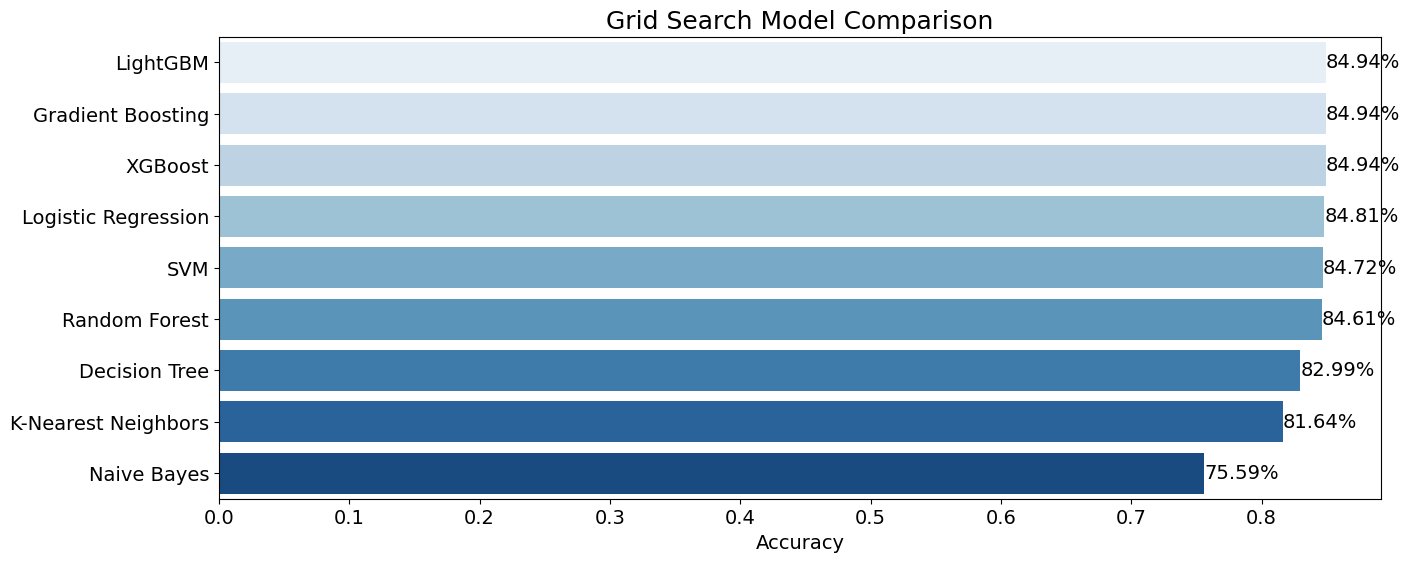

In [12]:
# Plotting the results
plt.figure(figsize=(15, 6))
# sns.barplot(x=[result["accuracy"] for result in best_model_results_sorted.values()],
#             y=best_model_results_sorted.keys(), 
#             palette='Blues')

sns.barplot(
    x=[result["accuracy"] for result in best_model_results_sorted.values()],
    y=list(best_model_results_sorted.keys()),
    palette='Blues'
)

plt.xlabel('Accuracy', fontsize=14)
plt.title('Grid Search Model Comparison',fontsize=18)

# Increase the tick label font sizes, including model names
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)  # Adjust font size of the model names


# Add accuracy labels
for i, (name, result) in enumerate(best_model_results_sorted.items()):
    plt.text(result["accuracy"], i, f'{result["accuracy"]*100:.2f}%', color='black', va='center', fontsize=14)

# Save the plot to a file
plt.savefig(f'{FIG_PATH}mental_health_model_comparison_grid_search.png', bbox_inches='tight', dpi=300)
plt.show()


In [13]:
def get_best_params(model_name, best_model_results):
    """
    Retrieve the best parameters for a specified model.

    Parameters:
    - model_name (str): The name of the model (e.g., "Logistic Regression").
    - best_model_results (dict): Dictionary containing accuracy and best parameters for each model.

    Returns:
    - dict: Best parameters for the specified model or a message if the model is not found.
    """
    if model_name in best_model_results:
        return best_model_results[model_name]["best_params"]
    else:
        return f"Model '{model_name}' not found in the results."

## Plot confusion matrices for the top-3 models

[LightGBM] [Info] Number of positive: 10406, number of negative: 5986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003625 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634822 -> initscore=0.552959
[LightGBM] [Info] Start training from score 0.552959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


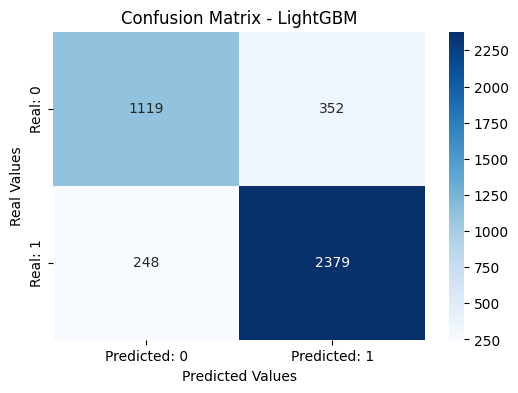

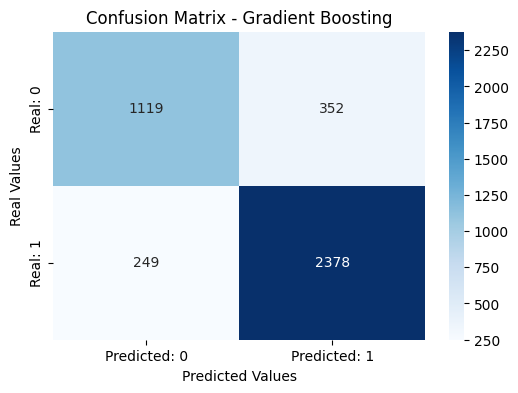

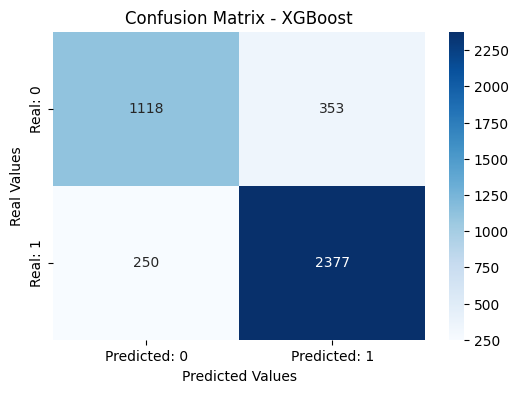

In [14]:
# Get the top 3 models from GridSearchCV (assumed to be sorted by accuracy in best_model_results_sorted)
top_3_models = list(best_model_results_sorted.keys())[:3]

# Create a list to store confusion matrices for the top 3 models
confusion_matrices = {}

for model_name in top_3_models:
    # Initialize the model using the best parameters
    best_params = get_best_params(model_name, best_model_results)
    
    if model_name == "XGBoost":
        model = xgb.XGBClassifier(random_state=42, **best_params)
    elif model_name == "Gradient Boosting":
        model = GradientBoostingClassifier(random_state=42, **best_params)
    elif model_name == "LightGBM":
        model = lgb.LGBMClassifier(random_state=42, **best_params)

    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Get predictions
    y_pred = model.predict(X_test_scaled)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices[model_name] = cm

    # Plot and save the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted: 0', 'Predicted: 1'], yticklabels=['Real: 0', 'Real: 1'])
    plt.title(f'Confusion Matrix - {model_name}')
    plt.xlabel('Predicted Values')
    plt.ylabel('Real Values')

    # Save the plot for each model
    plt.savefig(f'{FIG_PATH}{model_name}_confusion_matrix.png', bbox_inches='tight', dpi=300)
    plt.show()


## Plot ROC Curves for top-3 model

[LightGBM] [Info] Number of positive: 10406, number of negative: 5986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003761 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634822 -> initscore=0.552959
[LightGBM] [Info] Start training from score 0.552959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


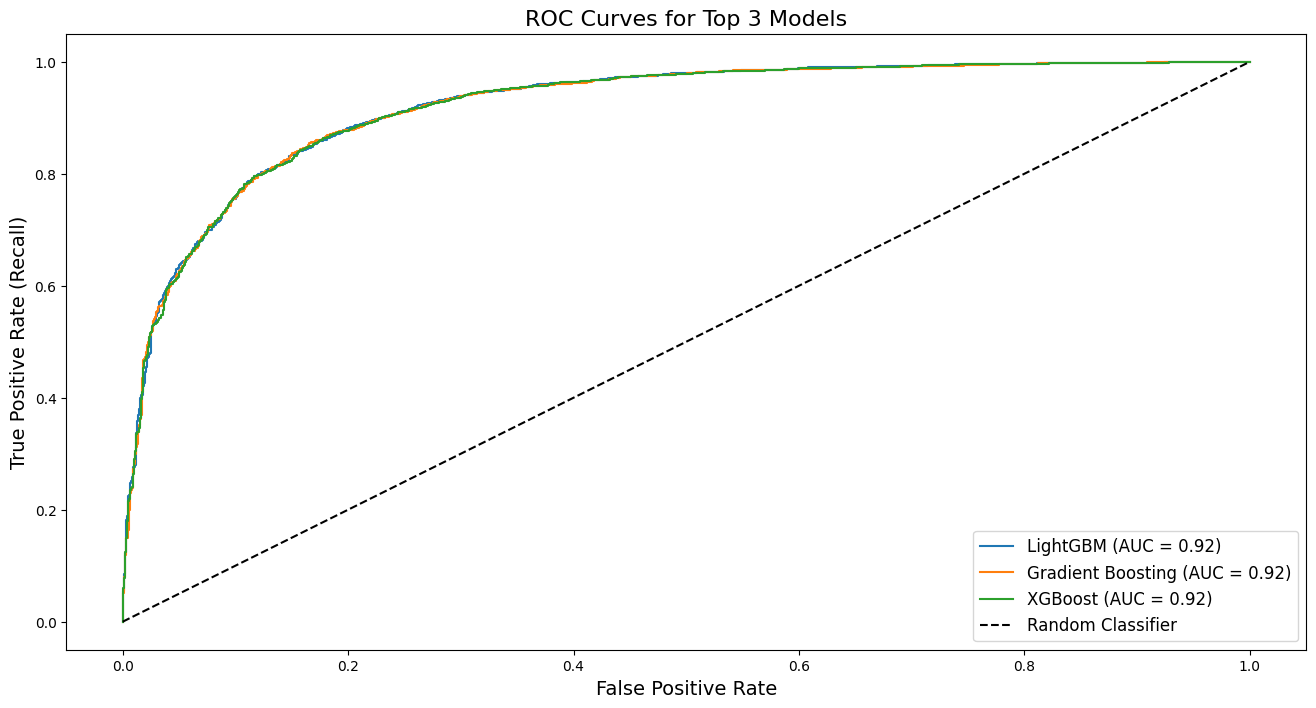

In [15]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Get the top 3 models from GridSearchCV (assumed to be sorted by accuracy in best_model_results_sorted)
top_3_models = list(best_model_results_sorted.keys())[:3]

# Initialize a figure for plotting ROC curves
plt.figure(figsize=(16, 8))

# Iterate over the top 3 models
for model_name in top_3_models:
    # Initialize the model using the best parameters
    best_params = get_best_params(model_name, best_model_results)
    
    if model_name == "XGBoost":
        model = xgb.XGBClassifier(random_state=42, **best_params)
    elif model_name == "Gradient Boosting":
        model = GradientBoostingClassifier(random_state=42, **best_params)
    elif model_name == "LightGBM":
        model = lgb.LGBMClassifier(random_state=42, **best_params)

    # Train the model
    model.fit(X_train_scaled, y_train)
    
    # Get predictions probabilities (for ROC curve, need probability scores)
    y_prob = model.predict_proba(X_test_scaled)[:, 1]  # Get the probability of the positive class
    
    # Compute the ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    
    # Compute the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

# Plot the diagonal line (random classifier)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

# Labels and title
plt.title('ROC Curves for Top 3 Models', fontsize=16)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate (Recall)', fontsize=14)
plt.legend(loc='lower right', fontsize=12)

# Save the plot
plt.savefig(f'{FIG_PATH}top_3_models_roc_curves.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()


# Next we perform XAI on the top-performing model(s)

## Feature Importance Analysis

['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes', 'XGBoost', 'LightGBM']
XGBoost Accuracy: 85.29%


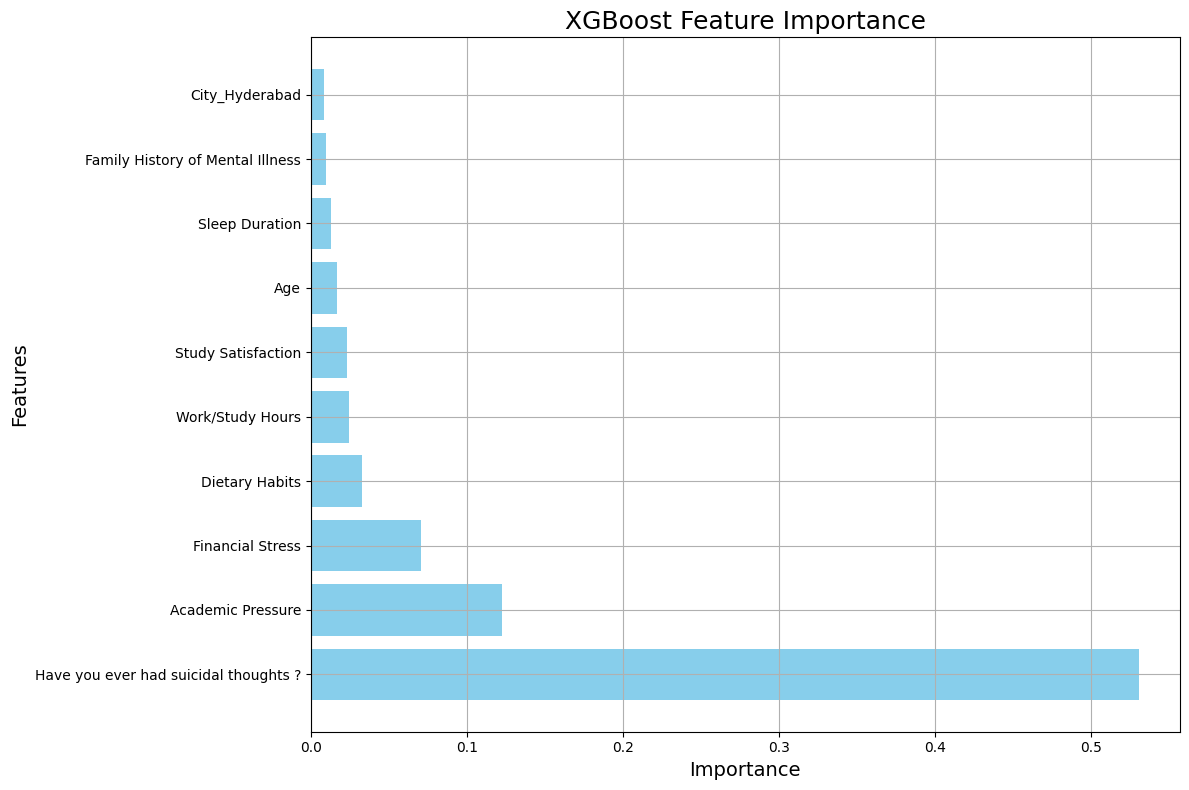

1. Have you ever had suicidal thoughts ?: 0.530563
2. Academic Pressure: 0.122575
3. Financial Stress: 0.070847
4. Dietary Habits: 0.032663
5. Work/Study Hours: 0.024271
6. Study Satisfaction: 0.023316
7. Age: 0.016861
8. Sleep Duration: 0.012873
9. Family History of Mental Illness: 0.009773
10. City_Hyderabad: 0.008397


In [16]:
model_names_str = list(models.keys())
print(model_names_str)
model_name = "XGBoost"
best_params = get_best_params(model_name, best_model_results)


#Get feature names
feature_names =  df.drop('Depression', axis=1).columns

# Initialize the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=42,learning_rate = 0.1,max_depth = 3, n_estimators=200)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {accuracy*100:.2f}%")

# Visualize the feature importance
plt.figure(figsize=(12, 8))

# Get feature importances
importance = xgb_model.feature_importances_

# Sort features by importance
indices = np.argsort(importance)[::-1]

# Select top 10 features
top_features = indices[:10]

# Create a horizontal bar plot
plt.barh(range(len(top_features)), importance[top_features], color='skyblue')

# Set y-axis labels to actual feature names
plt.yticks(range(len(top_features)), [feature_names[i] for i in top_features])

plt.title("XGBoost Feature Importance", fontsize=18)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.tight_layout()
plt.grid()
# Save the plot as a PNG image
plt.savefig(f'{FIG_PATH}xgboost_feature_importance_horizontal.png', bbox_inches='tight', dpi=300)
plt.show()

# Optional: Print out the top 10 features and their importance scores
for f in range(len(top_features)):
    print("%d. %s: %f" % (f + 1, feature_names[top_features[f]], importance[top_features[f]]))

['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'SVM', 'K-Nearest Neighbors', 'Naive Bayes', 'XGBoost', 'LightGBM']
Gradient Boosting Accuracy: 85.33%


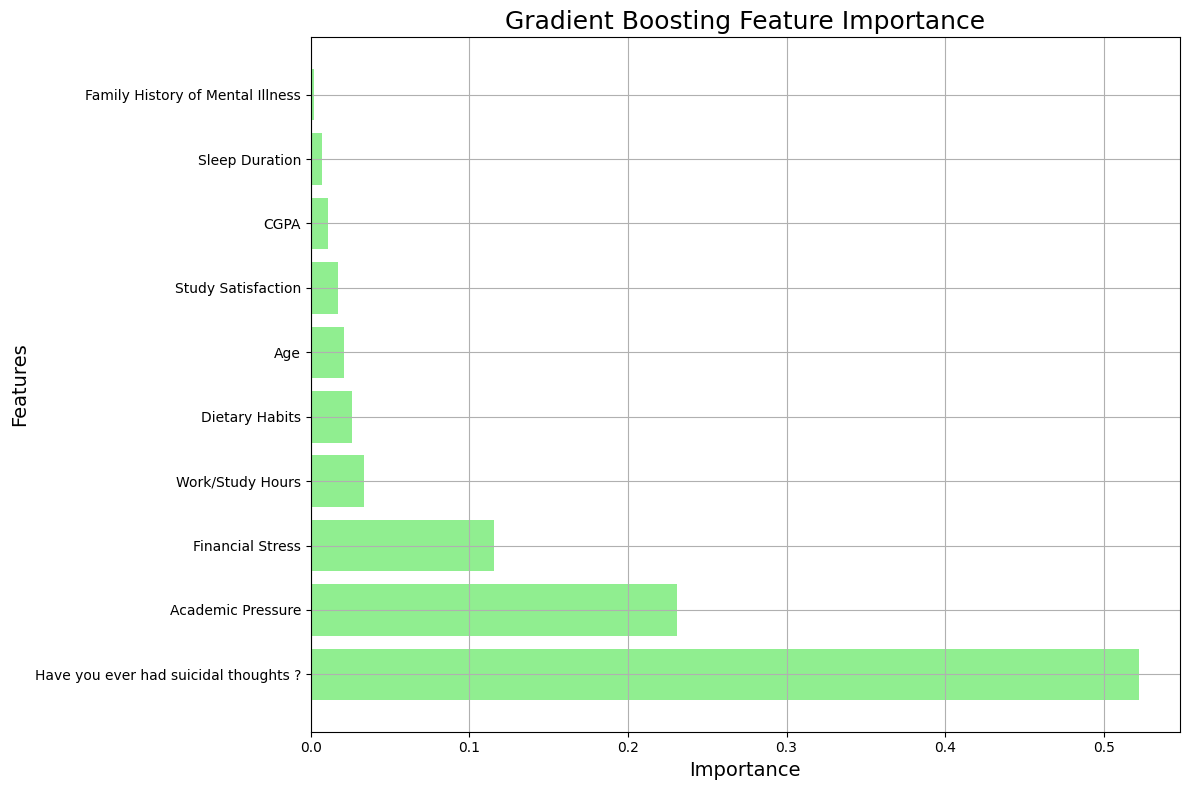

1. Have you ever had suicidal thoughts ?: 0.521981
2. Academic Pressure: 0.230845
3. Financial Stress: 0.115713
4. Work/Study Hours: 0.033874
5. Dietary Habits: 0.026013
6. Age: 0.020854
7. Study Satisfaction: 0.017150
8. CGPA: 0.011101
9. Sleep Duration: 0.007390
10. Family History of Mental Illness: 0.002002


In [17]:
# Define model names and best parameters
model_names_str = list(models.keys())
print(model_names_str)
model_name = "Gradient Boosting"
best_params = get_best_params(model_name, best_model_results)

# Get feature names
feature_names = df.drop('Depression', axis=1).columns

# Initialize the Gradient Boosting model with best parameters
gb_model = GradientBoostingClassifier(random_state=42, **best_params)

# Train the model
gb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = gb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Gradient Boosting Accuracy: {accuracy*100:.2f}%")

# Visualize the feature importance
plt.figure(figsize=(12, 8))

# Get feature importances
importance = gb_model.feature_importances_

# Sort features by importance
indices = np.argsort(importance)[::-1]

# Select top 10 features
top_features = indices[:10]

# Create a horizontal bar plot
plt.barh(range(len(top_features)), importance[top_features], color='lightgreen')

# Set y-axis labels to actual feature names
plt.yticks(range(len(top_features)), [feature_names[i] for i in top_features])

plt.title("Gradient Boosting Feature Importance", fontsize=18)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.tight_layout()
plt.grid()

# Save the plot as a PNG image
plt.savefig(f'{FIG_PATH}gradient_boosting_feature_importance_horizontal.png', bbox_inches='tight', dpi=300)
plt.show()

# Optional: Print out the top 10 features and their importance scores
for f in range(len(top_features)):
    print("%d. %s: %f" % (f + 1, feature_names[top_features[f]], importance[top_features[f]]))


[LightGBM] [Info] Number of positive: 10406, number of negative: 5986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003687 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634822 -> initscore=0.552959
[LightGBM] [Info] Start training from score 0.552959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM Accuracy: 85.36%


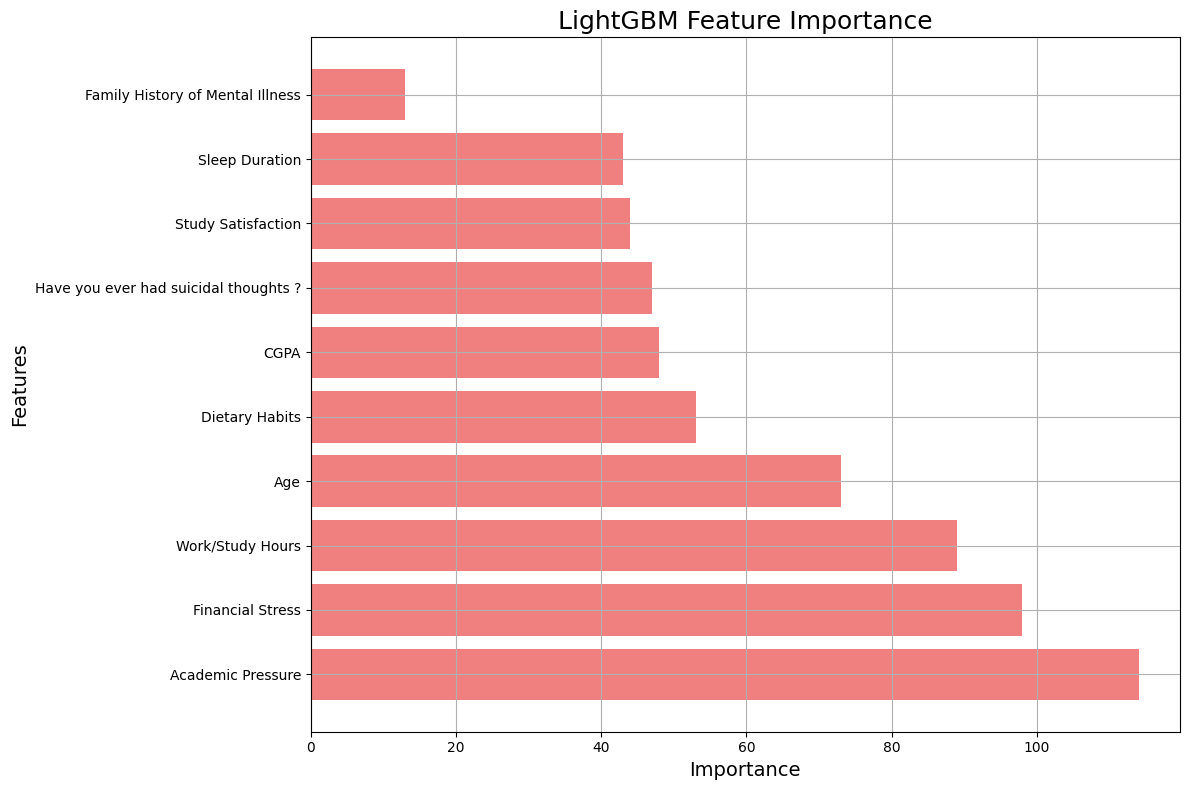

1. Academic Pressure: 114.000000
2. Financial Stress: 98.000000
3. Work/Study Hours: 89.000000
4. Age: 73.000000
5. Dietary Habits: 53.000000
6. CGPA: 48.000000
7. Have you ever had suicidal thoughts ?: 47.000000
8. Study Satisfaction: 44.000000
9. Sleep Duration: 43.000000
10. Family History of Mental Illness: 13.000000


In [18]:
# Define model names and best parameters
model_names_str = list(models.keys())
# print(model_names_str)
model_name = "LightGBM"
best_params = get_best_params(model_name, best_model_results)

# Get feature names
feature_names = df.drop('Depression', axis=1).columns

# Initialize the LightGBM model with best parameters
lgb_model = lgb.LGBMClassifier(random_state=42, **best_params)

# Train the model
lgb_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = lgb_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"LightGBM Accuracy: {accuracy*100:.2f}%")

# Visualize the feature importance
plt.figure(figsize=(12, 8))

# Get feature importances
importance = lgb_model.feature_importances_

# Sort features by importance
indices = np.argsort(importance)[::-1]

# Select top 10 features
top_features = indices[:10]

# Create a horizontal bar plot
plt.barh(range(len(top_features)), importance[top_features], color='lightcoral')

# Set y-axis labels to actual feature names
plt.yticks(range(len(top_features)), [feature_names[i] for i in top_features])

plt.title("LightGBM Feature Importance", fontsize=18)
plt.xlabel("Importance", fontsize=14)
plt.ylabel("Features", fontsize=14)

plt.tight_layout()
plt.grid()

# Save the plot as a PNG image
plt.savefig(f'{FIG_PATH}lightgbm_feature_importance_horizontal.png', bbox_inches='tight', dpi=300)
plt.show()

# Optional: Print out the top 10 features and their importance scores
for f in range(len(top_features)):
    print("%d. %s: %f" % (f + 1, feature_names[top_features[f]], importance[top_features[f]]))


[LightGBM] [Info] Number of positive: 10406, number of negative: 5986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634822 -> initscore=0.552959
[LightGBM] [Info] Start training from score 0.552959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
XGBoost Accuracy: 85.29%
Gradient Boosting Accuracy: 85.33%
LightGBM Accuracy: 85.36%


<Figure size 1400x800 with 0 Axes>

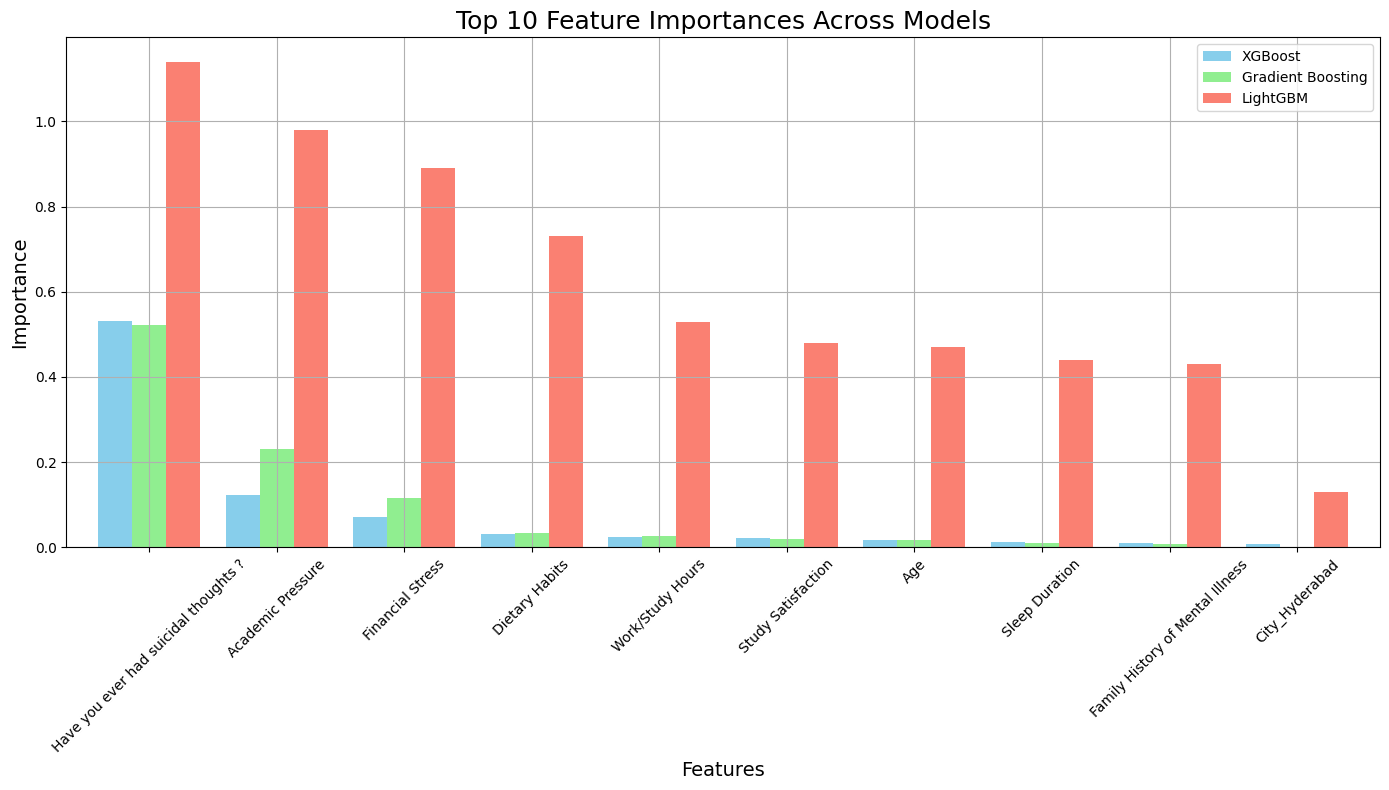

In [19]:
# Initialize the models with the best parameters from GridSearchCV
xgb_best_params = get_best_params("XGBoost", best_model_results)
gb_best_params = get_best_params("Gradient Boosting", best_model_results)
lgb_best_params = get_best_params("LightGBM", best_model_results)

# Initialize the models with best hyperparameters
xgb_model = xgb.XGBClassifier(random_state=42, **xgb_best_params)
gb_model = GradientBoostingClassifier(random_state=42, **gb_best_params)
lgb_model = lgb.LGBMClassifier(random_state=42, **lgb_best_params)

# Train the models
xgb_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
lgb_model.fit(X_train_scaled, y_train)

# Evaluate the models (for reference)
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_lgb = lgb_model.predict(X_test_scaled)

accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
accuracy_gb = accuracy_score(y_test, y_pred_gb)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)

print(f"XGBoost Accuracy: {accuracy_xgb*100:.2f}%")
print(f"Gradient Boosting Accuracy: {accuracy_gb*100:.2f}%")
print(f"LightGBM Accuracy: {accuracy_lgb*100:.2f}%")

# Get feature names (excluding the target column)
feature_names = df.drop('Depression', axis=1).columns

# Get the feature importances for each model
importance_xgb = xgb_model.feature_importances_
importance_gb = gb_model.feature_importances_
importance_lgb = lgb_model.feature_importances_

# Sort features by importance for each model
indices_xgb = np.argsort(importance_xgb)[::-1]
indices_gb = np.argsort(importance_gb)[::-1]
indices_lgb = np.argsort(importance_lgb)[::-1]

# Select top 10 features (or as many as needed)
top_n = 10
top_features_xgb = indices_xgb[:top_n]
top_features_gb = indices_gb[:top_n]
top_features_lgb = indices_lgb[:top_n]

# Collect the importance values for each model (top features)
importance_data = {
    "Feature": [feature_names[i] for i in top_features_xgb],
    "XGBoost": importance_xgb[top_features_xgb],
    "Gradient Boosting": importance_gb[top_features_gb],
    "LightGBM": importance_lgb[top_features_lgb]/100
}

# Convert the data to a DataFrame for easier plotting
import pandas as pd

importance_df = pd.DataFrame(importance_data)

# Plot the grouped bar plot
plt.figure(figsize=(14, 8))
importance_df.set_index("Feature").plot(kind='bar', width=0.8, color=['skyblue', 'lightgreen', 'salmon'], figsize=(14, 8))

plt.title("Top 10 Feature Importances Across Models", fontsize=18)
plt.xlabel("Features", fontsize=14)
plt.ylabel("Importance", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(True)

# Save the plot as a PNG image
plt.savefig(f'{FIG_PATH}model_comparison_feature_importance.png', bbox_inches='tight', dpi=300)
plt.show()


## SHAP (Shapley Additive Explanations)

 93%|=================== | 3818/4098 [00:12<00:00]       

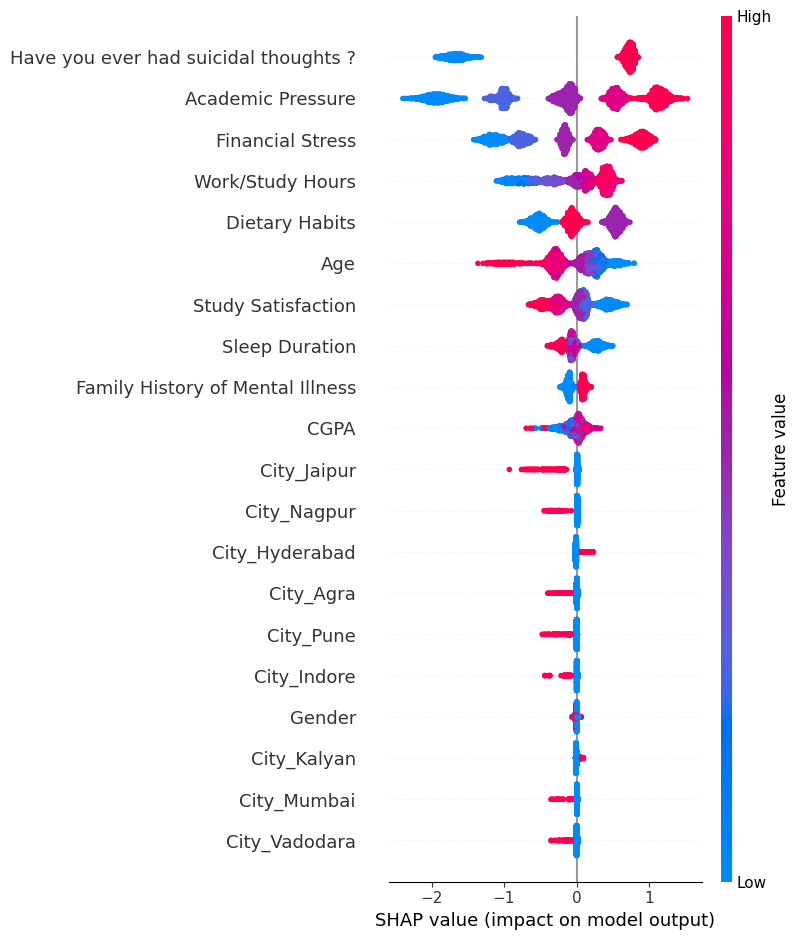

<Figure size 1000x800 with 0 Axes>

In [20]:

# Create a SHAP explainer object
explainer = shap.Explainer(xgb_model, X_train_scaled)
shap_values = explainer(X_test_scaled)

# Plot a summary plot for SHAP values
shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names)

# Optional: Create a force plot for a specific prediction
shap.initjs()  # to display JS visualizations in notebooks

plt.figure(figsize=(10, 8))
fig = shap.force_plot(shap_values[0],show=False)  # Visualize the first test sample
plt.savefig(f'{FIG_PATH}shap_original_summary_plot.png', bbox_inches='tight', dpi=300)
plt.show()


## 2. LIME (Local Interpretable Model-agnostic Explanations)


<Figure size 1000x800 with 0 Axes>

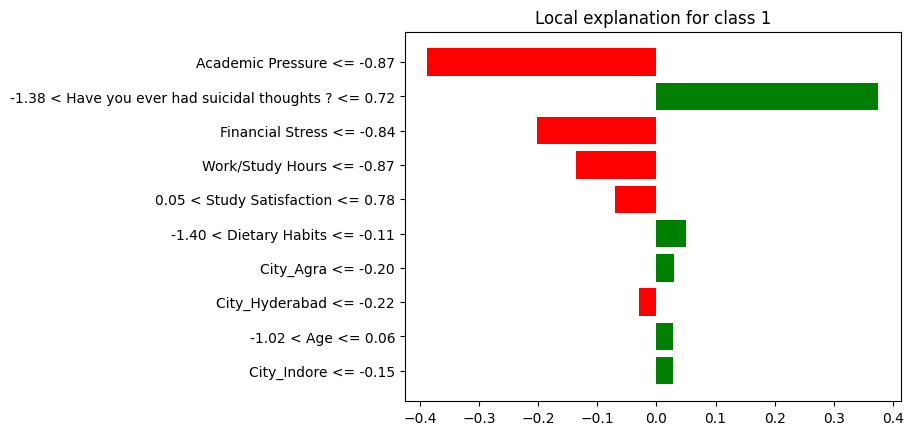

In [21]:


# Create a LIME explainer for the dataset
explainer = LimeTabularExplainer(X_train_scaled, training_labels=y_train, mode='classification', feature_names=feature_names)

# Explain a single prediction
exp = explainer.explain_instance(X_test_scaled[0], xgb_model.predict_proba, num_features=10)



plt.figure(figsize=(10, 8))
# Plot the explanation
fig = exp.as_pyplot_figure()
plt.savefig(f'{FIG_PATH}lime_tabular_summary_plot.png', bbox_inches='tight', dpi=300)
plt.show()


## TreeSHAP for Tree-based Models


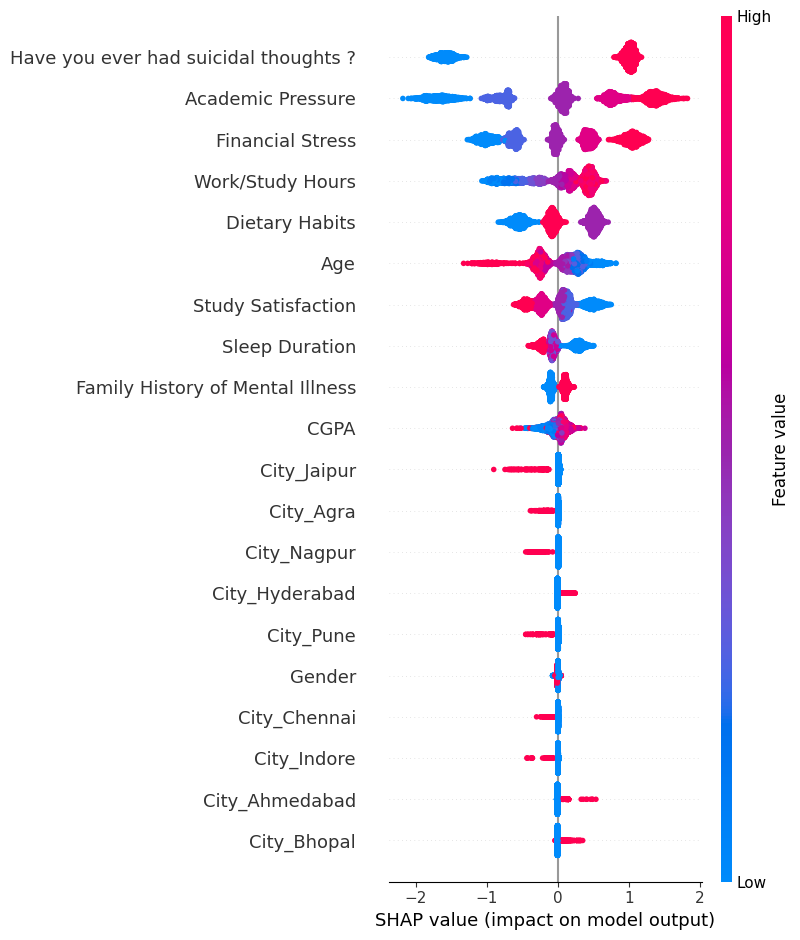

In [22]:


# TreeSHAP explanation for XGBoost
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_test_scaled)

plt.figure(figsize=(10, 8))
fig = shap.summary_plot(shap_values, X_test_scaled, feature_names=feature_names, show=False)
plt.savefig(f'{FIG_PATH}shap_summary_plot.png', bbox_inches='tight', dpi=300)
plt.show()


# We use Fairness Metrics with Fairlearn to investigate bias


In [23]:
X = df.drop('Depression', axis=1) 

zero_div_precision_score = partial(precision_score, zero_division=0)


In [24]:
# Define the models with best hyperparameters from GridSearchCV
xgb_best_params = get_best_params("XGBoost", best_model_results)
gb_best_params = get_best_params("Gradient Boosting", best_model_results)
lgb_best_params = get_best_params("LightGBM", best_model_results)

# Initialize the models with best hyperparameters
xgb_model = xgb.XGBClassifier(random_state=42, **xgb_best_params)
gb_model = GradientBoostingClassifier(random_state=42, **gb_best_params)
lgb_model = lgb.LGBMClassifier(random_state=42, **lgb_best_params)

# List of models to evaluate
models = {
    "XGBoost": xgb_model,
    "Gradient Boosting": gb_model,
    "LightGBM": lgb_model
}

# Train the models
xgb_model.fit(X_train_scaled, y_train)
gb_model.fit(X_train_scaled, y_train)
lgb_model.fit(X_train_scaled, y_train)

# Get predictions for each model
y_pred_xgb = xgb_model.predict(X_test_scaled)
y_pred_gb = gb_model.predict(X_test_scaled)
y_pred_lgb = lgb_model.predict(X_test_scaled)

y_preds = {
    "XGBoost": y_pred_xgb,
    "Gradient Boosting": y_pred_gb,
    "LightGBM": y_pred_lgb
}

# Function to compute fairness metrics for a given model and sensitive feature
def compute_fairness_metrics(y_true, y_pred, sensitive_features, sensitive_column_name):
    # Compute fairness metrics for each sensitive feature
    fairness_metrics = {}
    
    fairness_metrics['EOR'] = fairlearn.metrics.equalized_odds_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    fairness_metrics['DPD'] = fairlearn.metrics.demographic_parity_difference(y_true, y_pred, sensitive_features=sensitive_features)
    fairness_metrics['DPR'] = fairlearn.metrics.demographic_parity_ratio(y_true, y_pred, sensitive_features=sensitive_features)
    
    return fairness_metrics

# Iterate over models and sensitive columns to compute fairness metrics
sensitive_columns = X.columns.tolist()  # All feature column names
results = []

for model_name, model in models.items():
    # Get predictions for the model
    y_pred = y_preds[model_name]
    
    for column in sensitive_columns:
        # Get sensitive feature (assumed to be in X_test_scaled)
        sensitive_column_index = X.columns.tolist().index(column)
        sensitive_features = X_test_scaled[:, sensitive_column_index]
        
        # Compute fairness metrics
        fairness_metrics = compute_fairness_metrics(y_test, y_pred, sensitive_features, column)
        
        # Store results for the current model and sensitive feature
        row = {
            "Model": model_name,
            "Sensitive Feature": column,
            "EOR": fairness_metrics['EOR'],
            "DPD": fairness_metrics['DPD'],
            "DPR": fairness_metrics['DPR']
        }
        results.append(row)

# Create DataFrame to display results in tabular format
df_results = pd.DataFrame(results)

# Display the results as a table
print(df_results)


[LightGBM] [Info] Number of positive: 10406, number of negative: 5986
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003559 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 400
[LightGBM] [Info] Number of data points in the train set: 16392, number of used features: 42
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.634822 -> initscore=0.552959
[LightGBM] [Info] Start training from score 0.552959
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
        Model   Sensitive Feature       EOR       DPD       DPR
0     XGBoost              Gender  0.895034  0.015266  0.977314
1     XGBoost     

In [25]:
global_feature_names = feature_names 

### We visualize the fairness metrics for the top 10 important features

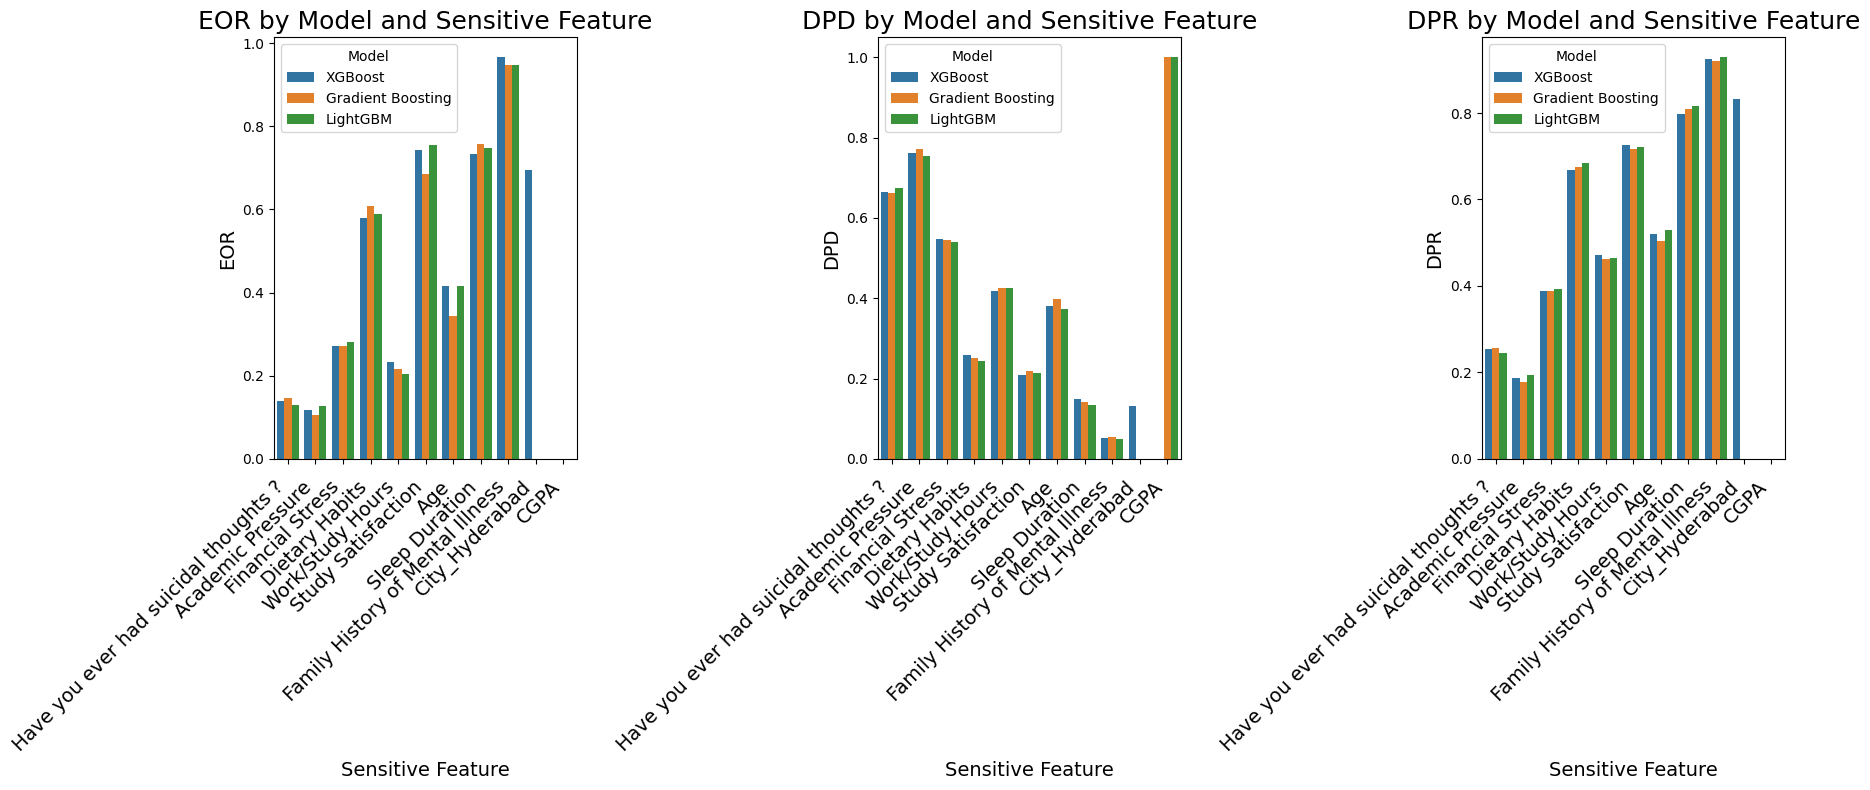

In [26]:
def get_top_features(model, X_train, n_top=10):
    # Check the type of model and use appropriate method
    if hasattr(model, 'feature_importances_'):
        # For tree-based models (XGBoost, Random Forest, etc.)
        feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'{global_feature_names[i]}' for i in range(X_train.shape[1])]
        
        feature_importances = model.feature_importances_
        top_indices = np.argsort(feature_importances)[::-1][:n_top]
        
        top_features = X_train[:, top_indices] if not isinstance(X_train, pd.DataFrame) else X_train.iloc[:, top_indices]
        top_feature_names = [global_feature_names[i] for i in top_indices]
        
        return top_features, top_indices, top_feature_names
    
    elif hasattr(model, 'coef_'):
        # For linear models (Logistic Regression, etc.)
        feature_names = X_train.columns if isinstance(X_train, pd.DataFrame) else [f'{global_feature_names[i]}' for i in range(X_train.shape[1])]
        
        feature_importances = np.abs(model.coef_[0])
        top_indices = np.argsort(feature_importances)[::-1][:n_top]
        
        top_features = X_train[:, top_indices] if not isinstance(X_train, pd.DataFrame) else X_train.iloc[:, top_indices]
        top_feature_names = [global_feature_names[i] for i in top_indices]
        
        return top_features, top_indices, top_feature_names
    
    else:
        raise ValueError("Model type not supported for feature importance")

# Prepare results for visualization
results_list = []
for model_name, model in models.items():
    # Get predictions for the model
    y_pred = y_preds[model_name]
    
    # Get top 10 features
    try:
        _, top_indices, top_feature_names = get_top_features(model, X_train)
    except ValueError:
        print(f"Skipping feature importance for {model_name}")
        continue
    
    for i, feature_name in enumerate(top_feature_names):
        # Get sensitive feature (assumed to be in X_test_scaled)
        sensitive_column_index = top_indices[i]
        sensitive_features = X_test_scaled[:, sensitive_column_index]
        
        # Compute fairness metrics
        fairness_metrics = compute_fairness_metrics(y_test, y_pred, sensitive_features, feature_name)
        
        # Add to results list
        for metric_name, metric_value in fairness_metrics.items():
            # print("Current feature name is ",feature_name)
            results_list.append({
                'Model': model_name,
                'Sensitive Feature': feature_name,
                'Metric': metric_name,
                'Value': metric_value
            })

# Convert to DataFrame
df_results = pd.DataFrame(results_list)

# Plotting
# Set up a figure with multiple subplots for each fairness metric
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # Adjust figure size for more space

# Bar plot for each fairness metric
metrics = ['EOR', 'DPD', 'DPR']
for idx, metric in enumerate(metrics):
    # Filter data for specific metric
    metric_data = df_results[df_results['Metric'] == metric]
    
    ax = axes[idx]
    sns.barplot(x='Sensitive Feature', y='Value', hue='Model', data=metric_data, ax=ax)
    
    ax.set_title(f'{metric} by Model and Sensitive Feature', fontsize=18)
    ax.set_xlabel('Sensitive Feature', fontsize=14)
    ax.set_ylabel(metric, fontsize=14)
    
    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=14)
    
    # Increase space between labels and plot
    ax.tick_params(axis='x', pad=10)

# Adjust layout to increase space between subplots and prevent overlap
plt.tight_layout(w_pad=3, h_pad=3)  # Increase horizontal and vertical padding
plt.savefig(f'{FIG_PATH}fairness_metrics.png', dpi=300, bbox_inches='tight')
plt.show()

### We now plot all the features using the fairness metrics

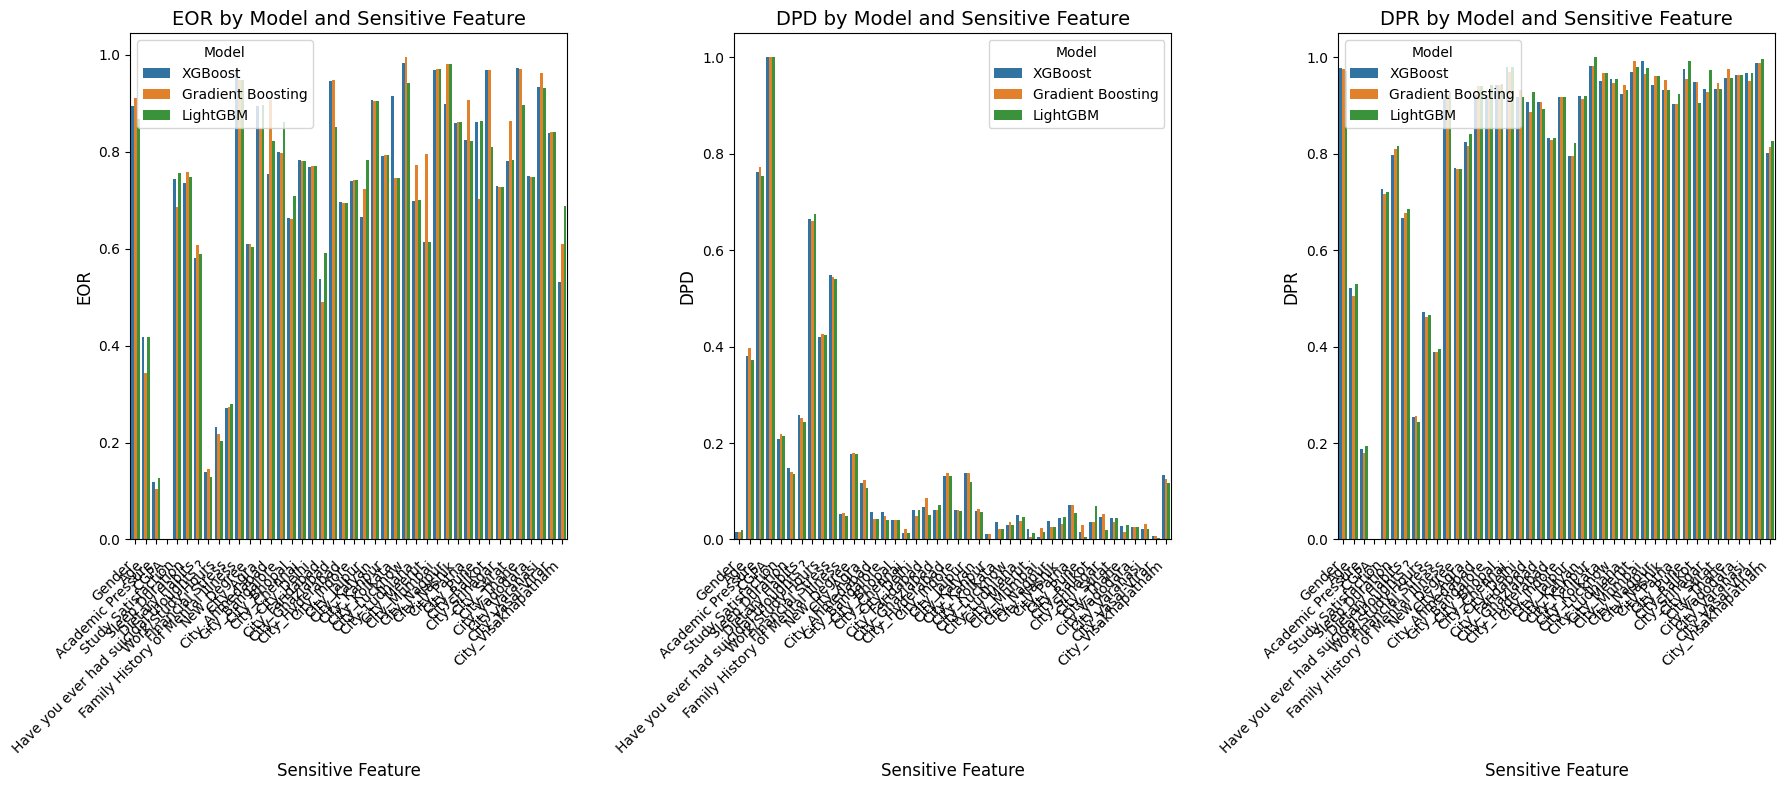

In [27]:
# Convert results to DataFrame
df_results = pd.DataFrame(results)

# Set up a figure with multiple subplots for each fairness metric
fig, axes = plt.subplots(1, 3, figsize=(18, 8))  # Adjust figure size for more space

# Bar plot for each fairness metric
for idx, metric in enumerate(['EOR', 'DPD', 'DPR']):
    ax = axes[idx]
    sns.barplot(x='Sensitive Feature', y=metric, hue='Model', data=df_results, ax=ax)
    ax.set_title(f'{metric} by Model and Sensitive Feature', fontsize=14)
    ax.set_xlabel('Sensitive Feature', fontsize=12)
    ax.set_ylabel(metric, fontsize=12)
    
    # Rotate the x-axis labels for better readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
    
    # Increase space between labels and plot
    ax.tick_params(axis='x', pad=10)

# Adjust layout to increase space between subplots and prevent overlap
plt.tight_layout(w_pad=3, h_pad=3)  # Increase horizontal and vertical padding
plt.savefig(f'{FIG_PATH}fairness_metrics_all_features.png', dpi=300, bbox_inches='tight')
plt.show()
